# Intro to classification

## Introduction
So far, we've been focussing on *regression* tasks in machine learning, in which the goal is to predict the value of a  continuous target. In this lesson, we'll shift our focus to *classification*, in which the goal is to predict the value of a discrete target variable.

Thus, we will be working within the following set-up: We are given a labelled (training) dataset with the following specifications:
- The dataset consists of $m$ instances.
- There are $n$ features $X_1,\dotsc,X_n$ (continuous or categorical) associated with each instance, each represented by a feature vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a target variable $Y$ that is categorical, and can take values in a finite set of *classes* $C = \{c_1,\dotsc,c_k\}$. This is represented by a target vector $\mathbf{y} \in C^m$. 
The goal of the classification model (referred to as a *classifier*) is to learn a ground truth function
\begin{equation*}
    f: \mathbb{R}^n \to C
\end{equation*}
which outputs a class label given a particular combination of values of the features. 

When $k=2$ (i.e. $C$ consists of only two classes), we have a *binary classification* problem. Binary targets can always be interpreted as yes/no answers to a question, such as "Is this email spam?" or "Does this patient have a particular disease?", or "Will this customer buy this product?".

When $k>2$, we have a *multi-class classification* problem.  Multi-class targets can similarly be interpreted as answers to questions such as "What type of animal is in this image?" or "What is the genre of this song?", or (in the case of large language models) "What is the next word in this sentence?".

### A visual perspective
Classification can be understood quite intuitively from a visual perspective. Namely, let's associate a color to each of the possible classes $c_1,\dotsc,c_k$. Then, we can visualize the dataset as a collection of $m$ points in the feature space $\mathbb{R}^n$. The goal of a classifier is to partition the feature space into $k$ regions $R_1,\dotsc,R_k$, each corresponding to a color $c_i$. To predict the class of a given a data point $\mathbf{r} \in \mathbb{R}^n$, the classifier simply checks which of these regions $R_i$ the point lies in, and it predicts the class to be the corresponding color $c_i$. 

The boundaries that separate the various regions in $\mathbb{R}^n$ are called **decision boundaries**, so named because the decision to assign a particular class changes when one crosses the boundary from one region to another. Classifiers are sometimes referred to as *linear classifiers*, *quadratic classifiers*, and so on, depending on the nature/curvature of these decision boundaries. 

The simplest to understand are the linear classifiers, which use decision boundaries that are straight lines/planes, etc. We will cover two well-known linear classifiers:
1. **Perceptrons**: The simplest possible linear classifier for binary classification that uses a step function to make predictions. These are the building blocks of neural networks.
2. **Logistic regression**: A linear classifier that uses a logistic function to make predictions. These are one of the most widely used classifiers in practice, and the multi-class version of logistic regression is used as the last step in many neural network architectures.

Below, we visualize a simple binary classification problem with two features, and the decision boundary of a logistic regression classifier. 

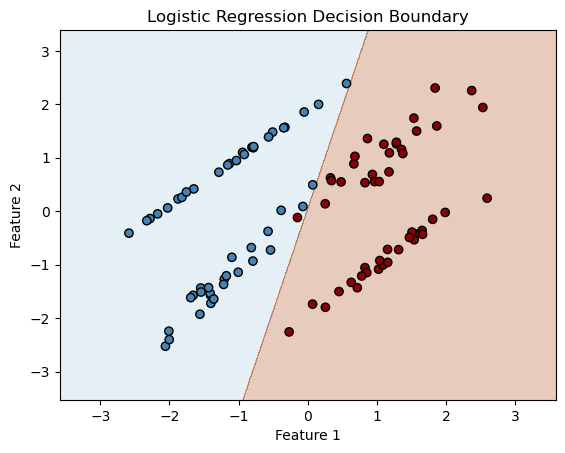

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generate synthetic data
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
colors = ['darkred' if label == 1 else 'steelblue' for label in y]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Create a mesh to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict probabilities for each point in the mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

We will discuss perceptrons and logistic regression in detail in the next two lessons. For this class, the goal will instead be to develop some basics of probability theory that will be useful for understanding these classifiers. To that end, we turn our attention to the concept of probabilistic classifiers. 

### Probabilistic Classifiers

A probabilistic classifier, also known as a **soft classifier**, is a type of classifier that outputs not just a class label for each input data point, but also a probability distribution over all possible class labels. This means that for each input, the classifier provides the probabilities that the input belongs to each of the possible classes; these are called **predicted probabilities**.

Given the output of a soft classifier, one can convert it into a **hard classifier** (which is one which predicts exactly one class label per instance) by simply taking the class with the highest probability. For example, if a soft classifier outputs the probabilities $P(c_1 | \mathbf{x}) = 0.7$, $P(c_2 | \mathbf{x}) = 0.2$, and $P(c_3 | \mathbf{x}) = 0.1$, then the hard classifier would predict class $c_1$ for the input $\mathbf{x}$. In some cases, one may want to use a different **decision threshold** for the probabilities, and classify an input as belonging to a certain class only if the probability exceeds a specific threshold. For example, one may want to classify an input as class $c_1$ only if $P(c_1 | \mathbf{x}) > 0.8$. (This notation will be explained below.)

Key characteristics of probabilistic classifiers include:

1. **Probability Distribution**: They provide a probability distribution over all classes, which sums to 1.
2. **Confidence Scores**: The probabilities can be interpreted as confidence scores, indicating how confident the classifier is in its predictions.
3. **Threshold Flexibility**: They allow for flexible decision thresholds; that is, you can classify an input as belonging to a certain class only if the probability exceeds a specific threshold.
4. **Uncertainty Quantification**: They enable the quantification of uncertainty in predictions, which is useful in many applications where understanding the uncertainty is important.

Our focus in this lesson will be on the **Naïve Bayes classifier**, which is a probabilistic classifier based on Bayes' theorem. First, let's introduce some basic concepts of probability theory that will be useful for understanding the Naïve Bayes classifier.

## Probability theory speedrun
In this section, we will cover some key concepts in probability theory that are relevant to classification tasks.

### 1. Probability spaces 
A probability space consists of a set of possible outcomes $\Omega$ (called the *sample space*), together with a probability measure $P$ that assigns a probability to each *event* (i.e. subset of $\Omega$). The probability measure must satisfy the following properties:
- $P(A) \geq 0$ for all events $A \subseteq \Omega$.
- $P(\Omega) = 1$.
- If $A_1, A_2, \dotsc$ are disjoint events (i.e. distinct subsets), then $P\left(\bigcup_i A_i\right) = \sum_i P(A_i)$.
In the context of ML, probability spaces arise naturally when we consider the possible values of a variable in a dataset. In these cases, the sample space is the set of all possible values that the variable can take (which we previously called the *support* of the variable), and the probability measure assigns a probability to each possible subset of values. 

Moreover, we saw that this measure arises naturally by constructing a suitable proabability function, which takes on two guises depending on whether the variable is continuous or discrete:
- In the discrete case, we have a probability mass function (PMF) $p_X: \Omega \to [0,1]$, which gives the probability that the random variable $X$ takes on the value $x$ (i,e, $p_X(x) = P(X=x)$). For a general event $S \subset \Omega$, the probability is given by $$P(S) = P(X \in S) = \sum_{x \in S} p_X(x).$$
- In the continuous case, we have a probability density function (PDF) $f_X: \Omega \to [0,\infty)$, which gives the density of the random variable $X$ at the value $x$. (Recall that the PDF can be understood as smoothed version of a histogram.) For a general event $S \subset \Omega$, the probability is given by $$P(S) = P(X \in S) = \int_S f_X(x) dx.$$

### 2. Joint probabilities
If we have two variables $X_1$ and $X_2$, with sample spaces $\Omega_1$ and $\Omega_2$, then we may wish to consider the probability of both variables taking on particular values simultaneously. That is:
- We first create a new sample space $\Omega_1 \times \Omega_2$, which consists of all possible pairs $(x_1, x_2)$, where $x_1 \in \Omega_1$ and $x_2 \in \Omega_2$.
- Then, for any event $S \subset \Omega_1 \times \Omega_2$, we define the joint probability $P(S)$ as the probability that both $X_1$ and $X_2$ take on values in $S$:
$$P(S) = P((X_1, X_2) \in S).$$
Joint probabilities for more than two distributions are defined similarly.

A probability distribution for a single variable is sometimes called the **marginal distribution** of that variable. This can be visualized as a histogram or a curve, with the $x$-axis representing the sample space $\Omega$, and the $y$-values representing the probabilities or densities. In either case, the total area under the curve (or of the histogram bins) must equal 1.

For two variables, the joint distribution can be visualized as a 3D surface (or histogram with 3D pillars), with the $x$- and $y$-axes representing the sample spaces $\Omega_1$ and $\Omega_2$, and the $z$-axis representing the joint probabilities. This time, the  total *volume* under the surface (or of the histogram pillars) must equal 1. Let's illustrate this by visualizing the joint distribution of two discrete variables from the `car_evaluation` dataset.

In [60]:
# import libraries
import numpy as np
import pandas as pd

cars = pd.read_csv('../data/classification/car_evaluation/train.csv')
vars = pd.read_csv('../data/classification/car_evaluation/data_description.csv')
vars = vars[['new_col_name', 'name', 'type', 'role']]
vars

,new_col_name,name,type,role
0,X1,buying,Categorical,Feature
1,X2,maint,Categorical,Feature
2,X3,doors,Categorical,Feature
3,X4,persons,Categorical,Feature
4,X5,lug_boot,Categorical,Feature
5,X6,safety,Categorical,Feature
6,Y,class,Categorical,Target


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider
import matplotlib.gridspec as gridspec

np.random.seed(0)
# Use the categorical columns directly (they should contain the class names)
X1 = cars['X1'].values  # Expected values: 'low', 'med', 'high', 'vhigh'
Y = cars['Y'].values    # Expected values: 'unacc', 'acc', 'good', 'vgood'

# Manually created lists for desired ordering
x1_order = ['low', 'med', 'high', 'vhigh']
y_order = ['unacc', 'acc', 'good', 'vgood']

def plot_3d_hist(azim=45, elev=30):
    # Use the manually defined order for X1 and Y
    x_unique = np.array(x1_order)
    y_unique = np.array(y_order)
    
    # Compute the joint frequency count
    counts = np.zeros((len(y_unique), len(x_unique)))
    for i, y_val in enumerate(y_unique):
        for j, x_val in enumerate(x_unique):
            counts[i, j] = np.sum((X1 == x_val) & (Y == y_val))
            
    total = counts.sum()            
    # Normalize counts to probabilities 
    prob = counts / total
            
    # Compute marginal distributions
    marg_x1 = counts.sum(axis=0) / total
    marg_y = counts.sum(axis=1) / total
            
    # Prepare data for the 3D joint plot
    xpos, ypos = np.meshgrid(np.arange(len(x_unique)), np.arange(len(y_unique)))
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = 0.8
    dy = 0.8
    dz = prob.flatten()
            
    # Create a figure with subplots using GridSpec:
    fig = plt.figure(figsize=(8, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[3, 1],
                           hspace=0.3, wspace=0.3)
            
    # X1 marginal distribution (top left)
    ax_x = fig.add_subplot(gs[0, 0])
    ax_x.bar(x_unique, marg_x1, color=(0.7, 0.8, 1, 0.7), width=0.8)
    ax_x.set_xticks(np.arange(len(x_unique)))
    ax_x.set_xticklabels(x_unique)
    ax_x.set_xlabel('X1 Categories')
    ax_x.set_ylabel('Probability')
    ax_x.set_title('Marginal Distribution of X1')
            
    # Y marginal distribution (bottom right)
    ax_y = fig.add_subplot(gs[1, 1])
    ax_y.barh(np.arange(len(y_unique)), marg_y, color=(0.7, 0.8, 1, 0.7), height=0.8)
    ax_y.set_yticks(np.arange(len(y_unique)))
    ax_y.set_yticklabels(y_unique)
    ax_y.set_ylabel('Y Categories')
    ax_y.set_xlabel('Probability')
    ax_y.set_title('Marginal Distribution of Y')
            
    # Joint 3D histogram (bottom left)
    ax_joint = fig.add_subplot(gs[1, 0], projection='3d')
    ax_joint.bar3d(xpos, ypos, zpos, dx, dy, dz, color=(0.7, 0.8, 1, 0.7), shade=True)
    ax_joint.set_xticks(np.arange(len(x_unique)) + dx/2)
    ax_joint.set_xticklabels(x_unique)
    ax_joint.set_yticks(np.arange(len(y_unique)) + dy/2)
    ax_joint.set_yticklabels(y_unique)
    ax_joint.set_zlabel('Probability')
    ax_joint.set_xlabel('X1')
    ax_joint.set_ylabel('Y')
    ax_joint.azim = azim
    ax_joint.elev = elev
    ax_joint.set_title('Joint Distribution of X1 and Y')
            
    plt.suptitle('3D Histogram with Marginal Distributions (Bad to Good)', fontsize=16)
    plt.show()

interact(
    plot_3d_hist,
    azim=IntSlider(min=0, max=360, step=5, value=45, description='Azimuth'),
    elev=IntSlider(min=0, max=90, step=5, value=30, description='Elevation')
)

interactive(children=(IntSlider(value=45, description='Azimuth', max=360, step=5), IntSlider(value=30, descrip…

<function __main__.plot_3d_hist(azim=45, elev=30)>

### 3. Conditional probabilities
Conditional probabilities are a way to quantify the likelihood of an event given that another event has occurred. The conditional probability of event $A$ given event $B$ is denoted by $P(A|B)$, and is defined as
$$P(A|B) = \frac{P(A \cap B)}{P(B)},$$
provided that $P(B) > 0$. The logic for this formula is as follows:
- The probability of $A$ and $B$ both occurring (i.e. the joint probability) is given by $P(A \cap B)$. The probability of $A$ *not* occuring simultaneously as $B$ occurs is given by $P(A^c \cap B)$.
- The sum of the above two quantities is the probability that $B$ occurs, i.e. $P(B)$. Therefore, the probability that $A$ occurs given that $B$ occurs is the ratio of the probability that both occur to the probability that $B$ occurs.
- Note that, when we add up the joint probabilities of $B$ with all possible values of $A$, we get $P(B)$. Thus, dividing by $P(B)$ has the effect of normalizing the joint probabilities (i.e. converting them into conditional probabilities) that add up to $1$. In effect, we've restricted our sample space to the event $B$, and are now considering the probabilities of $A$ within this restricted space!

In the context of ML, the event $B$ typically comes from one variable, and the event $A$ comes from another variable. For example, if we have a discrete feature $X$ and target $Y$, then $P(Y|X)$ is the probability of the target $Y$ given the feature $X$. More precisely, given values $x$ and $y$ of $X$ and $Y$, respectively, $P(Y=y|X=x)$ is the probability that the target is $y$ given that the feature is $x$. By the above formula, we have
\begin{equation*}
    P(Y=y|X=x) = \frac{P(Y=y, X=x)}{P(X=x)}.
\end{equation*}
This formula is the basis for the Naïve Bayes classifier, which we will discuss a couple of sections down.

First, let's illustrate the concept of conditional probabilities by visualizing the conditional distribution of the target variable given the feature `X3` (i.e. `doors`) from the `car_evaluation` dataset.

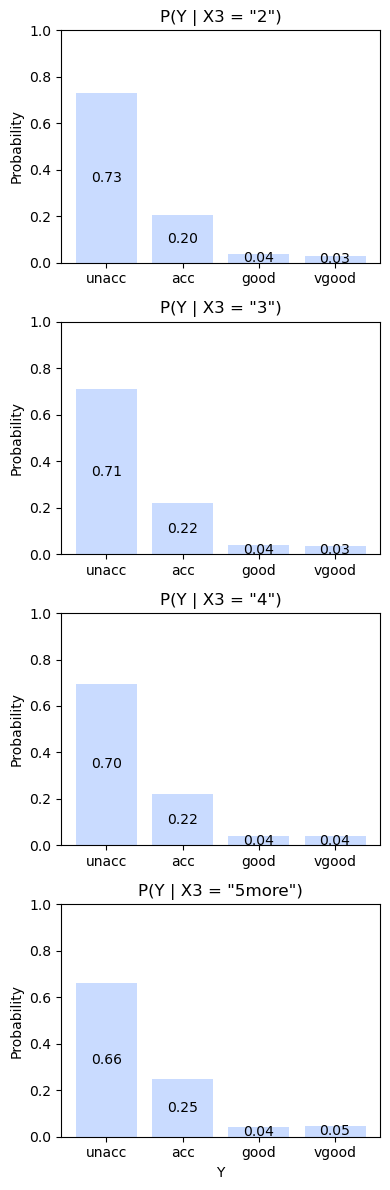

In [62]:
# Get the possible unique values (and ordering if desired) for X3 and Y.
x3_order = sorted(cars['X3'].unique())  # e.g., ['2', '3', '4', '5more'] if these are the door categories
y_order = ['unacc', 'acc', 'good', 'vgood']

n_x3 = len(x3_order)
fig, axs = plt.subplots(n_x3, 1, figsize=(4, 3 * n_x3))
if n_x3 == 1:
    axs = [axs]

for i, x3_val in enumerate(x3_order):
    # Filter the dataset for the current X3 value
    subset = cars[cars['X3'] == x3_val]
    
    # Compute counts and then probabilities for each Y category
    counts = np.array([np.sum(subset['Y'] == y_val) for y_val in y_order])
    total = counts.sum()
    prob = counts / total if total > 0 else np.zeros_like(counts)
    
    ax = axs[i]
    bars = ax.bar(y_order, prob, color=(0.7, 0.8, 1, 0.7))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title(f'P(Y | X3 = "{x3_val}")')
    
    # Annotate each bar with its probability value inside the bar
    for bar, p in zip(bars, prob):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # horizontal center of the bar
            height / 2,                         # vertical position: mid-bar
            f'{p:.2f}',                         # formatted probability
            ha='center', va='center', color='black'
        )

plt.xlabel('Y')
plt.tight_layout()
plt.show()

### 4. Independence
The above visualization shows us that the probability distribution of `Y` does not appear to change much at all depending on the particular value of `X3`, i.e. it appears that the probability of `Y` is *independent* of `X3`. This leads us naturally to the fundamental concept of independence in probability theory: two events $A$ and $B$ are said to be independent if the occurrence of one does not affect the probability of the other. In other words, $A$ and $B$ are **independent** if $$P(A|B) = P(A),$$ or equivalently, if $$P(A \cap B) = P(A)P(B).$$

When the events arise from distinct variables, we say that the variables are independent if the events are independent for all possible values of the variables. In other words, two variables $X$ and $Y$ are independent if $$P(Y, X) = P(Y)P(X),$$
that is, the joint probability of the two variables is the product of the marginal probabilities. For example, the previous visualization suggests that the target `Y` and the feature `X3` are independent (almost). 

The notion of independence can be extended naturally to a collection of variables $X_1,\dotsc,X_n$: we say that these are independent if the joint probability of all the variables is the product of the marginal probabilities:
$$P(X_1, X_2, \dotsc, X_n) = P(X_1)P(X_2)\dotsb P(X_n).$$

### 5. Bayes' Theorem
Bayes' theorem is a fundamental result in probability theory that allows us to compute conditional probabilities in the reverse direction. It states that for any two events $A$ and $B$ with $P(B) > 0$, we have
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}.$$
This follows from the formula:
\begin{equation*}
    P(A \cap B) = P(A|B)P(B) = P(B|A)P(A).
\end{equation*}
You might think that this is trivial, since it follows immediately from the formula for conditional probability...

Yes. You're absolutely right. It is trivial. But it is also incredibly powerful, and the true power lies not so much in the actual formula, but in the intuition that it provides (the "Bayesian interpretation").
- The term $P(A)$ is called the **prior probability** of $A$, and represents our initial belief in the likelihood of $A$.
- The term $P(B|A)$ is called the **likelihood**, and represents the probability of observing $B$ given that $A$ is true.
- The term $P(A|B)$ is called the **posterior probability**, and represents our updated belief in the likelihood of $A$ given that we have observed $B$.
- The term $P(B)$ is called the **evidence**, and represents the probability of observing $B$.
Re-phrasing it in this language, we have:
\begin{equation*}
    \text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{evidence}}.
\end{equation*}
This is the essence of Bayesian reasoning: we start with a prior belief, update it based on new evidence, and obtain a new belief. This is the basis for the Naïve Bayes classifier, which we will discuss in the next section.

### 6. Bayes classifier with one feature
Suppose we have a single feature $X$ and categorical target $Y$ with sample space $\{c_1,\dotsc,c_k\}$.  The **Bayes classifier** is a probabilistic classifier that predicts the class label that maximizes the posterior probability. That is, using Bayes' theorem, we have
\begin{equation*}
    P(Y = c_i|X = x) = \frac{P(X=x|Y = c_i)P(Y = c_i)}{P(X=x)},
\end{equation*}
or, more succintly, 
\begin{equation*}
    P(c_i|x) = \frac{P(x|c_i)P(c_i)}{P(x)}.
\end{equation*}
Here:
- $P(x|c_i)$ is the likelihood of observing $x$ given that the class is $c_i$.
- $P(c_i)$ is the prior probability of the class $c_i$.
- $P(x)$ is the evidence.
- $P(c_i|x)$ is the posterior probability of the class $c_i$ given the evidence $x$; this is what we want to maximize.

With this setup, the predicted class label for a given feature $x$ is the class $c_i$ that maximizes the posterior probability $P(c_i|x)$:
\begin{align*}
    \hat{y} & = \argmax_{c_i} \; P(c_i|x)\\
    & = \argmax_{c_i} \; \frac{P(x|c_i)P(c_i)}{P(x)}\\
    & = \argmax_{c_i} \; P(x|c_i)P(c_i)\\
    & = \argmax_{c_i} \; P(X=x, Y=c_i).
\end{align*}
Note: above, we simply dropped the denominator $P(x)$, since it is the same for all classes and does not affect the maximization. 

NOTE: The quantity $P(x|c_i)$ is to be interpreted as a probability density or mass function, depending on whether $X$ is continuous or discrete. 

### 7. Bayes classifier with multiple features
When we have multiple features $X_1,\dotsc,X_n$, the Bayes classifier can be generalized as follows. The predicted class label for a given feature vector $\mathbf{r} = (x_1,\dotsc,x_n)$ is the class $c_i$ that maximizes the posterior probability $P(c_i|\mathbf{r})$. To simplify notation, let $\vec{X}$ denote the "vector-valued" variable $(X_1,\dotsc,X_n)$, which takes values that look like $\mathbf{r} = (x_1,\dotsc,x_n)$. In this case, Baye's Theorem tells us that
\begin{equation*}
    P(Y=c_i|\vec{X} = \mathbf{r}) = \frac{P(\vec{X} = \mathbf{r}|Y = c_i)P(Y = c_i)}{P(\vec{X} = \mathbf{r})}.
\end{equation*}
Here:
- $P(\vec{X} = \mathbf{r}|Y = c_i)$ is the likelihood of observing $\mathbf{r}$ given that the class is $c_i$.
- $P(Y = c_i)$ is the prior probability of the class $c_i$.
- $P(\vec{X} = \mathbf{r})$ is the evidence.
- $P(Y = c_i|\vec{X} = \mathbf{r})$ is the posterior probability of the class $c_i$ given
the evidence $\mathbf{r}$; this is what we want to maximize.

Then, the predicted class label for a given feature vector $\mathbf{r}$ is the class $c_i$ that maximizes the posterior probability $P(c_i|\mathbf{r})$:
\begin{align*}
    \hat{y} & = \argmax_{c_i} \; P(c_i|\mathbf{r})\\
    & = \argmax_{c_i} \; \frac{P(\mathbf{r}|c_i)P(c_i)}{P(\mathbf{r})}\\
    & = \argmax_{c_i} \; P(\mathbf{r}|c_i)P(c_i).
\end{align*}
Above, we again dropped the denominator $P(\mathbf{r})$, since it is the same for all classes and does not affect the maximization.

We illustrate the Bayes classifier on the cars dataset. (NOTE: this is only feasible because the dataset is small and has only a few features. In practice, the number of features can be very large, and the computation of the likelihoods can be infeasible. This is where the Naïve Bayes classifier comes in, in the next section.)

In [63]:
feature_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

#read in train and test set
cars = pd.read_csv('../data/classification/car_evaluation/train.csv')
cars_test = pd.read_csv('../data/classification/car_evaluation/test.csv')

# Create a joint frequency table for all features together with the target Y.
joint_counts = cars.groupby(feature_columns + ['Y']).size().reset_index(name='joint_count')

# Also compute the marginal counts for each Y value.
y_counts = cars.groupby('Y').size().reset_index(name='y_count')

# Merge the tables to compute conditional probabilities P(X1, ..., X6 | Y=y)
joint_counts = joint_counts.merge(y_counts, on='Y')
joint_counts['P_X_given_Y'] = joint_counts['joint_count'] / joint_counts['y_count']

print("Joint conditional probabilities:")
print(joint_counts)

# For making predictions on a new instance (or instances), you would work as follows.
def predict_class(instance, joint_counts, y_values):
    """
    instance: a dict with keys as feature names (from feature_columns) and their corresponding categorical values
    joint_counts: DataFrame with joint frequencies and conditional probabilities
    y_values: list/array of all possible Y classes
    Returns: Dictionary mapping Y value to computed likelihood for the instance.
    """
    prob_dict = {}
    for y in y_values:
        # Filter the joint_counts for this class and for rows matching the instance's feature values.
        cond = (joint_counts['Y'] == y)
        for feat in feature_columns:
            cond = cond & (joint_counts[feat] == instance[feat])
        matching = joint_counts[cond]
        # If matching, use its probability; otherwise, use a small value (or zero).
        if not matching.empty:
            prob_dict[y] = matching['P_X_given_Y'].values[0]
        else:
            prob_dict[y] = 0.0  # or apply Laplace smoothing
    return prob_dict


# Example usage on an instance from a test dataframe (cars_test)
# Assume cars_test exists and has the same structure.
y_possible = cars['Y'].unique()

# Make predictions for all rows in cars_test
predictions = []
for _, row in cars_test.iterrows():
    test_instance = row[feature_columns].to_dict()
    likelihoods = predict_class(test_instance, joint_counts, y_possible)
    
    # Find class with highest likelihood
    predicted_class = max(likelihoods.items(), key=lambda x: x[1])[0] if any(likelihoods.values()) else 'unacc'
    predictions.append(predicted_class)

# Compare predictions with actual values
accuracy = sum(pred == actual for pred, actual in zip(predictions, cars_test['Y'])) / len(cars_test)
print(f"\nModel accuracy: {accuracy:.2%}")

# Print first few predictions and actual values
print("\nFirst few predictions:")
for i in range(min(5, len(cars_test))):
    print(f"Predicted: {predictions[i]}, Actual: {cars_test['Y'].iloc[i]}")

Joint conditional probabilities:
         X1     X2     X3    X4     X5    X6      Y  joint_count  y_count  \
0      high   high      2     2    big  high  unacc            1      968   
1      high   high      2     2    big   low  unacc            1      968   
2      high   high      2     2    med   low  unacc            1      968   
3      high   high      2     2    med   med  unacc            1      968   
4      high   high      2     2  small   low  unacc            1      968   
...     ...    ...    ...   ...    ...   ...    ...          ...      ...   
1377  vhigh  vhigh  5more  more    med   low  unacc            1      968   
1378  vhigh  vhigh  5more  more    med   med  unacc            1      968   
1379  vhigh  vhigh  5more  more  small  high  unacc            1      968   
1380  vhigh  vhigh  5more  more  small   low  unacc            1      968   
1381  vhigh  vhigh  5more  more  small   med  unacc            1      968   

      P_X_given_Y  
0        0.001033  
1 

In [64]:
cars_test

,X1,X2,X3,X4,X5,X6,Y
0,low,low,4,more,med,med,good
1,med,vhigh,3,4,big,low,unacc
2,high,vhigh,5more,4,small,high,unacc
3,med,med,2,2,small,low,unacc
4,high,high,3,more,big,high,acc
...,...,...,...,...,...,...,...
341,low,low,3,4,med,low,unacc
342,vhigh,med,3,more,med,high,acc
343,vhigh,low,4,4,small,low,unacc
344,med,med,3,2,big,med,unacc


### 7. Naïve Bayes Classifier
The Bayes classifier is simple to interpret and easy to implement when all the features are discrete. In practice, however, we often have continuous features, and the computation of the likelihood $P(\mathbf{r}|c_i)$ can be quite complex. If you think about it, the likelihood is a joint probability of all the features given the class, and this can be quite difficult to estimate accurately for continuous variables. 

The **Naïve Bayes classifier** tries to deal with this issue by making a simplifying assumption: it assumes that the features are **conditionally independent** given the class label. This means that if we fix any class label $c$ and only look at instances in that class, the features are assumed to be independent of each other. Mathematically, this assumption can be written as
$$P(\vec{X} = (x_1,\dotsc,x_n) | Y=c) = \prod_{i=1}^n P(X_i=x_i | Y=c).$$
In other words, the probability of observing a particular combination of feature values given a class label is the product of the probabilities of observing each feature value given the class label.

This assumption greatly simplifies the computation of the posterior probabilities, as we can now write
$$P(Y=c | \vec{X} = (x_1,\dotsc,x_n)) = \frac{P(Y=c) \prod_{i=1}^n P(X_i=x_i | Y=c)}{P(\vec{X} = (x_1,\dotsc,x_n))}.$$
So, here:
- The prior is again $P(Y=c)$.
- The likelihood is now the product $\prod_{i=1}^n P(X_i=x_i | Y=c)$. To estimate this quantity, we need to estimate the conditional marginal distributions of each feature given the class label (which is far more tractable than estimating the joint distribution of all features).
- The evidence $P(\vec{X} = (x_1,\dotsc,x_n))$ is the same for all classes, so we can ignore it when comparing the posterior probabilities for different classes. 
- The posterior probability is again $P(Y=c | \vec{X} = (x_1,\dotsc,x_n))$.

To summarize, the Naïve Bayes classifier makes predictions by computing the posterior probability:
\begin{align*}
    \hat{y} & = \argmax_{c_i} \; P(c_i|\mathbf{r})\\
    & = \argmax_{c_i} \; P(\mathbf{r}|c_i)P(c_i)\\
    & = \argmax_{c_i} \; P(c_i) \prod_{j=1}^n P(x_j|c_i).
\end{align*}

We illustrate the Naïve Bayes classifier on the `iris` dataset.

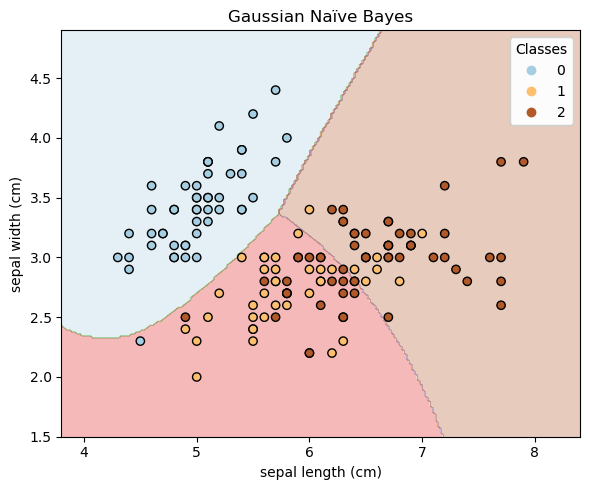

In [66]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # Select only two features for visualization
y = iris.target       # Three class labels (0, 1, 2)

# Train Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X, y)

# Function to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    # Set the plot boundaries
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Create new figure
    plt.figure(figsize=(6, 5))
    
    # Plot decision regions
    contour = plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k')
    
    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)
    
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.title(title)
    
    return plt.gca()

# Plot decision boundary for GaussianNB
ax = plot_decision_boundary(gnb, X, y, "Gaussian Naïve Bayes")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import make_pipeline

# Sample text dataset
texts = [
    "I love programming in Python",
    "Python is great for machine learning",
    "I hate bugs in my code",
    "Debugging is frustrating but rewarding",
    "Machine learning is fascinating",
    "I enjoy solving coding challenges",
    "Syntax errors are annoying",
]

# Corresponding labels (1 = positive, 0 = negative)
labels = np.array([1, 1, 0, 0, 1, 1, 0])

# MultinomialNB: Uses raw word counts as features
vectorizer_mnb = CountVectorizer(binary=False)  # Keep word counts
X_mnb = vectorizer_mnb.fit_transform(texts)
mnb = MultinomialNB()
mnb.fit(X_mnb, labels)

# BernoulliNB: Uses binary presence/absence of words
vectorizer_bnb = CountVectorizer(binary=True)  # Convert counts to binary
X_bnb = vectorizer_bnb.fit_transform(texts)
bnb = BernoulliNB()
bnb.fit(X_bnb, labels)

# Test on a new sentence
test_text = ["Python debugging is fun but sometimes annoying"]

# Transform test text using both vectorizers
X_test_mnb = vectorizer_mnb.transform(test_text)
X_test_bnb = vectorizer_bnb.transform(test_text)

# Predict using both models
mnb_prediction = mnb.predict(X_test_mnb)
bnb_prediction = bnb.predict(X_test_bnb)

# Print predictions
print(f"MultinomialNB Prediction: {'Positive' if mnb_prediction[0] == 1 else 'Negative'}")
print(f"BernoulliNB Prediction: {'Positive' if bnb_prediction[0] == 1 else 'Negative'}")

Here’s a code example comparing Multinomial Naïve Bayes (MNB) and Bernoulli Naïve Bayes (BNB) using a simple text classification task with scikit-learn.

What This Code Does
	1.	Creates a toy text dataset (a few sample sentences categorized into two classes).
	2.	Converts text into numerical features using CountVectorizer (for MultinomialNB) and TfidfVectorizer (for BernoulliNB with binary features).
	3.	Trains and evaluates both classifiers on the dataset.
	4.	Compares their behavior on binary vs. count-based features.

Expected Output

Since MultinomialNB relies on word counts, and BernoulliNB focuses on word presence, their predictions may differ. For example:

MultinomialNB Prediction: Positive
BernoulliNB Prediction: Negative

This happens because:
	•	MultinomialNB considers the frequency of words (e.g., “Python” and “debugging” appearing more often in positive examples).
	•	BernoulliNB only considers whether words appear at all, ignoring how many times they appear.

Key Takeaways
	•	MultinomialNB is sensitive to word frequency, making it useful for text classification where word counts matter (e.g., spam detection).
	•	BernoulliNB is binary (word presence/absence matters, not frequency), making it better for shorter texts or cases where frequent words don’t add extra meaning.